### Part 2.3

In [1]:
import scipy.signal as sig
import skimage as sk
import skimage.io as skio
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import skimage.transform as sktr

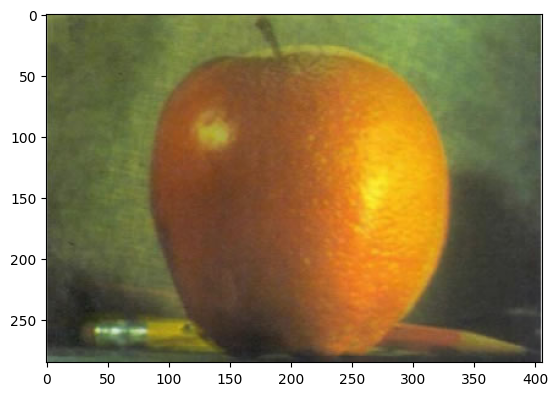

In [470]:
im1 = cv2.imread("./images/oraple.png")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)

In [462]:
def getStacksMasked(im1, boundary):
    gaussian = cv2.getGaussianKernel(10, 15)
    gaussian = gaussian * gaussian.T

    mask = np.zeros_like(im1[:,:,0])
    mask[:, boundary:] = 1

    gaussianStackR = [im1[:,:,0]/np.max(im1[:,:,0])]
    gaussianStackG = [im1[:,:,1]/np.max(im1[:,:,1])]
    gaussianStackB = [im1[:,:,2]/np.max(im1[:,:,2])]
    gaussianFilters = [mask]

    gaussianStackRGB = [gaussianStackR, gaussianStackG, gaussianStackB]
    for _ in range(0, 12):
        gaussianFilters.append(sig.convolve2d(gaussianFilters[-1], gaussian, mode="same", boundary='symm'))
        for i in range(0, 3):
            temp = np.clip(sig.convolve2d(gaussianStackRGB[i][-1], gaussian, mode="same", boundary='symm'), 0, None)
            gaussianStackRGB[i].append(temp/np.max(temp))

    laplaceStackR = []
    laplaceStackG = []
    laplaceStackB = []

    laplaceStackRGB = [laplaceStackR, laplaceStackG, laplaceStackB]
    for i in range(0, 3):
        for b in range(12, 0, -1):
            temp = np.clip(gaussianStackRGB[i][b] - gaussianStackRGB[i][b-1], 0, None)
            laplaceStackRGB[i].append(temp/np.max(temp))
            # print((gaussianStackRGB[i][b] - gaussianStackRGB[i][b-1]).shape)
        laplaceStackRGB[i] = list(reversed(laplaceStackRGB[i]))
    return gaussianFilters, gaussianStackRGB, laplaceStackRGB

In [474]:
filters, fullGaussian, fullLaplace = getStacksMasked(im1, 200)

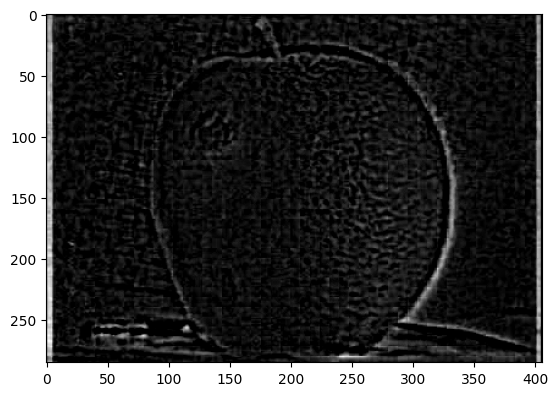

In [475]:
img = np.stack((fullLaplace[0][0] * im1[:,:,0],fullLaplace[1][0]* im1[:,:,1],fullLaplace[2][0])* im1[:,:,2], axis=2)
# img[img<0] = np.abs[img[img<0]]
plt.imshow(fullLaplace[0][0], cmap='grey')
# plt.imshow(img)

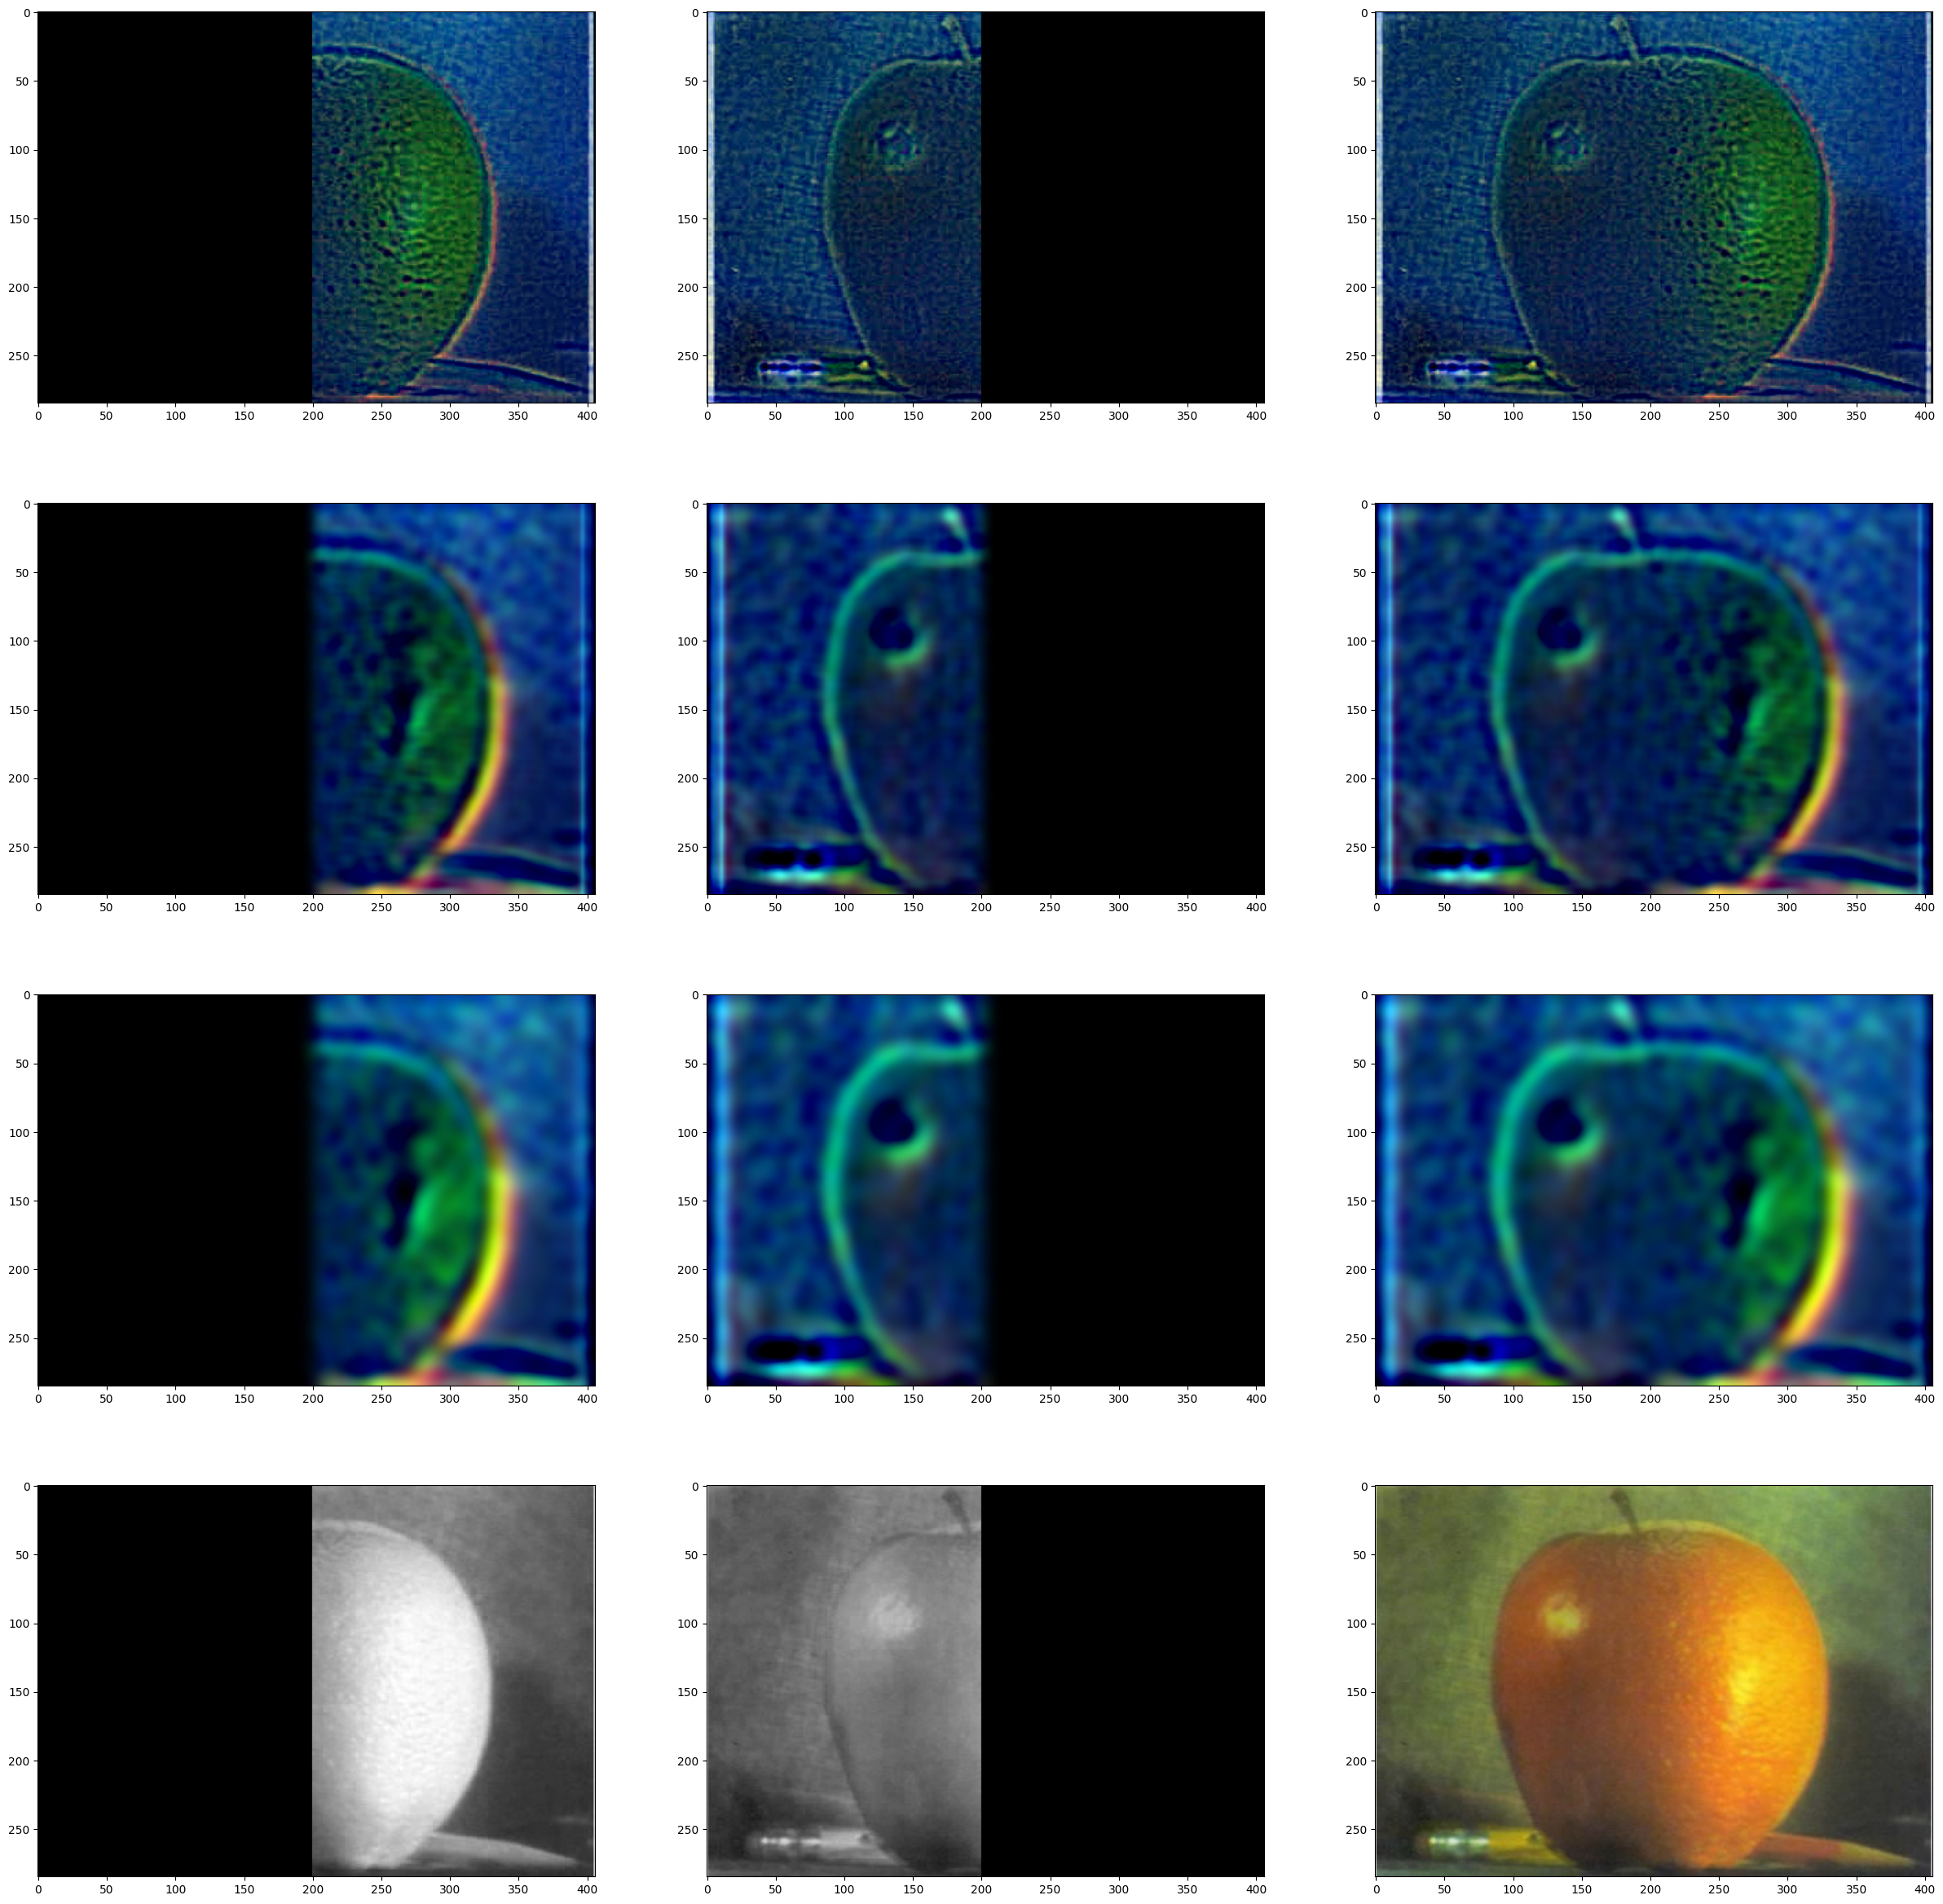

In [476]:
fig, axs = plt.subplots(4, 3, figsize=(30, 30))

for i in range(0, 3):
    full = np.stack((fullLaplace[0][i*4], fullLaplace[1][i*2], fullLaplace[2][i*2]), axis=2)
    left = np.stack((fullLaplace[0][i*4]* filters[i*2], fullLaplace[1][i*2]* filters[i*2], fullLaplace[2][i*2]* filters[i*2]), axis=2)
    # right = np.stack(((fullLaplace[0][i*2] * im1[:,:,0])/np.max(fullLaplace[0][i*2] * im1[:,:,0]) * (1-filters[i*2]), (fullLaplace[1][i*2] * im1[:,:,1]/np.max(fullLaplace[1][i*2] * im1[:,:,1])) * (1-filters[i*2]), (fullLaplace[2][i*2] * im1[:,:,2]/np.max(fullLaplace[2][i*2] * im1[:,:,2])) * (1-filters[i*2])), axis=2)
    right = np.stack((fullLaplace[0][i*4]* (1-filters[i*2]), fullLaplace[1][i*2] * (1-filters[i*2]), fullLaplace[2][i*2]* (1-filters[i*2])), axis=2)

    axs[i][0].imshow((left).astype(np.float32))
    axs[i][1].imshow((right).astype(np.float32))
    axs[i][2].imshow((full).astype(np.float32))

left = np.stack((im1[:,:,0] * filters[0], im1[:,:,0]* filters[0], im1[:,:,0]* filters[0]), axis=2)
axs[3][0].imshow((left/np.max(left)).astype(np.float32))

right = np.stack((im1[:,:,0]* (1-filters[0]), im1[:,:,0]* (1-filters[0]), im1[:,:,0]* (1-filters[0])), axis=2)
axs[3][1].imshow((right/np.max(right)).astype(np.float32))

full = np.stack((im1[:,:,0], im1[:,:,1], im1[:,:,2]), axis=2)
axs[3][2].imshow((full/np.max(full)).astype(np.float32))